# Making the mass-ratio priors
In this notebook, I will use the compiled companion and primary star data to estimate the mass-ratio prior for each of my detections.

The process will be:

1. Get the primary star mass
  - If it is in the David & Hillenbrand sample, use their mass
  - Otherwise, use the spectral type
  - Use Teff/logg from my ccfs and evolutionary tracks to get mass?
2. Get the companion mass. Use the corrected temperature and convert to mass
  - Use the Dartmouth evolutionary tracks to get a model grid mass
    - Use the David & Hillenbrand age, if available
    - Use the main-sequence age otherwise
  - Interpolate spectral type relationships

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py

import logging
import Priors

logger = logging.getLogger()
logger.setLevel(logging.WARN)
#logging.basicConfig(level=logging.DEBUG,
#                   filename='run.log',
#                    filemode='w')

%matplotlib inline

In [2]:
# Read in the companion temperature data
summary = pd.read_csv('Corrected_Companion_Data.csv', sep='|').drop_duplicates(subset=['Star'])

# Primary star mass estimates

Note that I adjusted the primary mass estimate for HIP 78821 by hand. That one very strongly disagreed with the spectral type estimate, so I fit padova tracks to the following parameters, consistent with its B2V spectral type in Simbad:

- $T_{\rm eff} = 26000 \pm 2000\ K$
- $\log{g} = 4.0 \pm 0.25$
- [Fe/H] $= 0.0 \pm 0.5$

For all other stars, I estimate the primary mass from:

1. The posterior estimates in David & Hillenbrand (2015)
2. By fitting padova evolutionary tracks to the estimates for fundamental parameters. I estimate the fundamental parameters by cross-correlating the spectra against a grid of Kurucz model spectral spanning $7000\ K < T < 30000\ K$ and $3.0 < \log{g} < 4.5$

The correspondence between spectral type mass and the estimated mass is shown below:

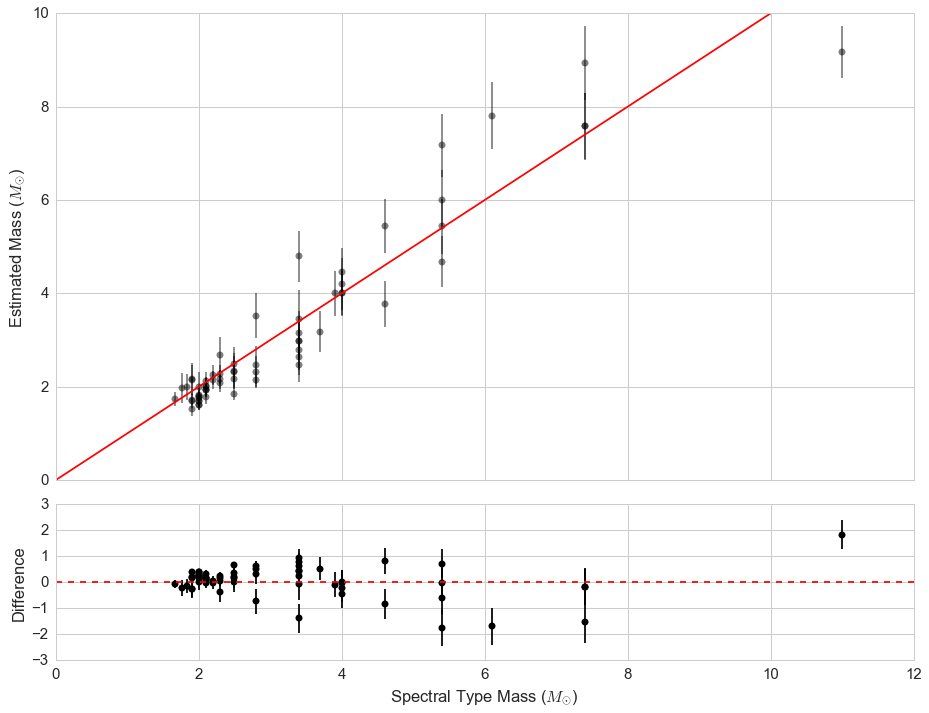

In [6]:
with h5py.File('Primary_Parameters.h5', 'r') as f:
    star_list = f.keys()

import SpectralTypeRelations
import Mamajek_Table
import StarData
import seaborn as sns
sns.set_context('notebook', font_scale=1.5)
sns.set_style('whitegrid')
MS = SpectralTypeRelations.MainSequence()
MT = Mamajek_Table.MamajekTable()
MT.mam_df['SpTNum'] = [MS.SpT_To_Number(s) for s in MT.mam_df.SpT]
sptnum2mass = MT.get_interpolator('SpTNum', 'Msun')

pad_mass = []
pad_std = []
spt_mass = []
for star in star_list:
    df = pd.read_hdf('Primary_Parameters.h5', star)
    pad_mass.append(df.mass.mean())
    pad_std.append(df.mass.std())
    spt = StarData.GetData(str(star.replace('_', ' '))).spectype
    sptnum = MS.SpT_To_Number(spt)
    spt_mass.append(sptnum2mass(sptnum))
    
# Turn into numpy arrays
pad_mass = np.array(pad_mass)
pad_std = np.array(pad_std)
spt_mass = np.array(spt_mass)
    
# Plot
fig, (top, bottom) = plt.subplots(2, 1, sharex=True, figsize=(13,10), 
                                  gridspec_kw=dict(height_ratios=(3,1)))
top.errorbar(spt_mass, pad_mass, yerr=pad_std, fmt='ko', alpha=0.5)
top.plot((0, 10), (0, 10), 'r-')
bottom.errorbar(spt_mass, spt_mass - pad_mass, yerr=pad_std, fmt='ko')
bottom.plot(bottom.get_xlim(), (0, 0), 'r--')

bottom.set_xlabel('Spectral Type Mass ($M_{\odot}$)')
bottom.set_ylabel('Difference')
top.set_ylabel('Estimated Mass ($M_{\odot}$)')
top.legend(loc='best', fancybox=True)

plt.tight_layout()
                                  

This is what the mass estimate posteriors look like:

(2.225286124575014, 5.0436810957900295)

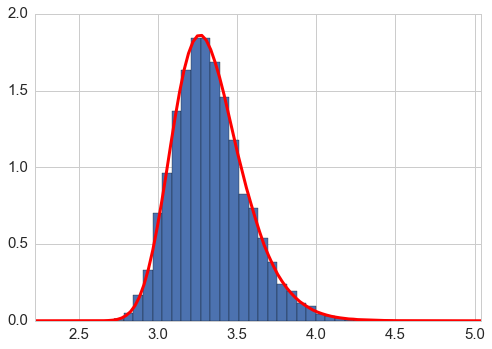

In [7]:
hipnum = '16611'
mass, prob = Priors.read_dh2015_posterior(hipnum=str(hipnum))
plt.plot(mass, prob, 'r-', lw=3)
mass_samples = Priors.get_primary_mass('HIP {}'.format(hipnum), spt='B2', size=1e4)
_ = plt.hist(mass_samples, bins=30, normed=True)
plt.xlim((mass_samples.min()-0.5, mass_samples.max()+0.5))

# Secondary Star Mass Estimates

I get the secondary star estimates in two ways as well, but save both of them instead of just the best one. In both cases, I start by sampling the effective temperature of the star (from the CCF analysis) and age estimate of the system (from the primary star estimate; same as above).

1. Spectral type interpolator: Convert the temperature samples into main sequence mass samples by interpolating the grid given [here](http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt)
2. Isochrone interpolator: Interpolate Greg Feiden's Dartmouth isochrones from temperature and age to mass

The plot below show the difference between the two methods for fairly typical parameters. The biggest difference is that the dartmouth posteriors look much better behaved. I prefer them because of that and for their ability to capture what is happening at young ages.

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


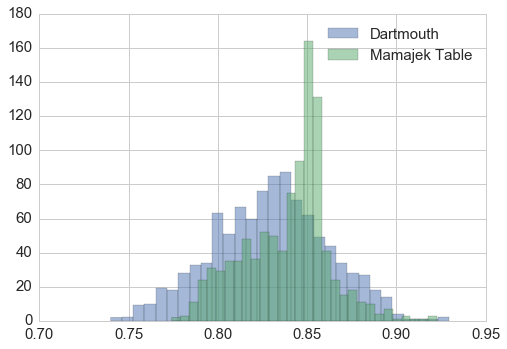

In [14]:
# Get mass samples from both the dartmouth and spectral type interpolator
dar = Priors.Feiden_Isochrone()
teff_samples = np.random.normal(loc=5000, scale=150, size=1e3)
iso_int = Priors.IsochroneInterpolator()
spt_int = Priors.SpectralTypeInterpolator()
dar_mass_samples = iso_int(teff_samples, 500.0)  # 500 Myr
spt_mass_samples = spt_int(teff_samples)

# Plot
plt.hist(dar_mass_samples, bins=30, alpha=0.5, label='Dartmouth')
plt.hist(spt_mass_samples, bins=30, alpha=0.5, label='Mamajek Table')
leg = plt.legend(loc='best', fancybox=True)


# Put everything together.
I will generate primary and secondary star mass estimates for every detection, and store them all in an HDF5 file. I will generate histograms of all of the samples along the way, so that I can check if anything looks weird.

In [5]:
summary.head()[['Star', 'configuration', 'SpT', 'vsini_sec', '[Fe/H]', 'Rank', 
                'Tmeas', 'Corrected_Temperature', 'T_lowerr', 'T_uperr', 'Mass', 'M1']]

,Star,configuration,SpT,vsini_sec,[Fe/H],Rank,Tmeas,Corrected_Temperature,T_lowerr,T_uperr,Mass,M1
0,HIP 2548,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,B9.5V,30,-0.5,1,5600.047668,5732.020192,111.956254,111.982127,0.999831,2.5
2,HIP 3478,B5V,B5V,5,-0.5,7,5799.802745,5524.152869,149.773113,149.773877,0.957460,4.6
3,HIP 5310,(A3V + ?; ?),A3V,30,0.0,3,3399.871770,3342.732718,154.357141,154.313632,0.352539,2.0
4,HR 545,B9V,B9.5IV,5,-0.5,1,4499.706320,4312.191145,87.255325,87.252411,0.728462,2.5
7,HR 604,(2.33K3IIb + 5.02(5.5(B7V + B9V; 2.67d) + 6.2A...,B8V+A0V,5,0.5,1,5000.070687,4735.568122,149.777704,149.773948,0.794541,3.4


In [15]:
iso_int = Priors.IsochroneInterpolator()
spt_int = Priors.SpectralTypeInterpolator()
logger.setLevel(logging.INFO)

N = 1e4
HDF5_OUTPUT = 'data/OrbitPrior.h5'
with h5py.File(HDF5_OUTPUT, 'w') as outfile:
    for idx, row in summary.iterrows():
        # Get primary mass samples
        hipnum = row['Star'].split('HIP')[-1].strip()
        primary_mass = Priors.get_primary_mass(star=row['Star'], spt=row['SpT'], size=N, mass_err=0.1)

        # Get system age estimate
        age = Priors.get_ages(starname=row['Star'], spt=row['SpT'], size=N)

        # Get companion mass estimates
        teff_samples = np.random.normal(loc=row['Corrected_Temperature'],
                                        scale=max(row['T_lowerr'], row['T_uperr']),
                                        size=len(primary_mass))
        
        companion_isomass = iso_int(teff_samples, age)
        companion_sptmass = spt_int(teff_samples)

        # Save the data in the HDF5 file
        star_grp = outfile.create_group(row['Star'])
        _ = star_grp.create_dataset('primary', data=primary_mass)
        _ = star_grp.create_dataset('companion_isochrone', data=companion_isomass)
        _ = star_grp.create_dataset('companion_spectral_type', data=companion_sptmass)
        _ = star_grp.create_dataset('system_age', data=age)
        
        # Save the star data as attributes of the group.
        for col in ['SpT', 'configuration', 'vsini_sec', '[Fe/H]', 'Rank',
                    'Tmeas', 'Tmeas_err', 'Corrected_Temperature', 'T_lowerr', 'T_uperr']:
            star_grp.attrs[col] = row[col]
        
        outfile.flush()

INFO:root:Getting stellar data for HIP 37450
INFO:root:Main Sequence age for HIP 37450 is 50 Myr
INFO:root:Getting stellar data for HIP 46283


SELECT * FROM star WHERE name IN ('HIP 37450')
SELECT * FROM star WHERE name IN ('HIP 46283')

INFO:root:Main Sequence age for HIP 46283 is 63 Myr
INFO:root:Getting stellar data for HIP 96840



SELECT * FROM star WHERE name IN ('HIP 96840')

INFO:root:Main Sequence age for HIP 96840 is 50 Myr


In [16]:
# Make a raw mass-ratio distribution
def mode(a, bins=30):
    vals, bins = np.histogram(a[~np.isnan(a)], bins=bins)
    mode = bins[np.argmax(vals)]
    return mode
    
spt_q = []
iso_q = []
HDF5_OUTPUT = 'data/OrbitPrior.h5'
with h5py.File(HDF5_OUTPUT, 'r') as f:
    for starname, star_grp in f.iteritems():
        primary_mass = star_grp['primary'].value
        companion_isomass = star_grp['companion_isochrone']
        companion_sptmass = star_grp['companion_spectral_type']
        
        M1 = mode(primary_mass)
        M2_iso = mode(companion_isomass)
        M2_spt = mode(companion_sptmass)
        spt_q.append(min(M1/M2_spt, M2_spt/M1))
        iso_q.append(min(M1/M2_iso, M2_iso/M1))

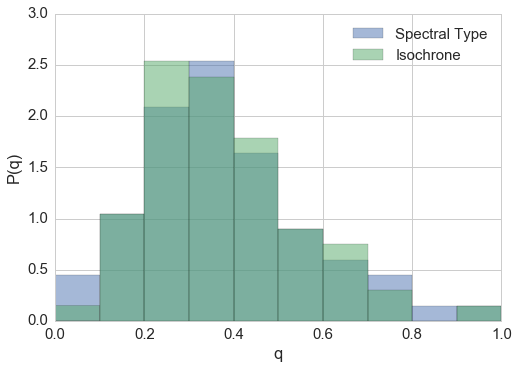

In [17]:
bins = np.arange(0, 1.05, 0.1)
plt.hist(spt_q, bins=bins, alpha=0.5, label='Spectral Type', normed=True)
plt.hist(iso_q, bins=bins, alpha=0.5, label='Isochrone', normed=True)
leg = plt.legend(loc='best', fancybox=True)
plt.xlabel('q')
plt.ylabel('P(q)')

The mass-ratio distribution for the two methods is almost indistinguishable. That is good!